# **Common Prosperity Simulation**
## Computational Physics Lab 
Author: Yuan-Yen Peng, Chih-Tian Ho  
E-mail: garyphys0915@gapp.nthu.edu.tw, chihtian.ho@gapp.nthu.edu.tw  
Dept of Physics, NTHU, Taiwan   
Date: SOMEDATE  
Version: 2.1.3  
License: MIT

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pathlib import Path
from numba import jit, njit, prange
import time

### initial conditions

In [ ]:
# initial setup
problem_name = 'Common_Prosperity'
io_screen = True
io_freq = 5 # how many step to record the data
io_title = problem_name

In [ ]:
# setup
size = int(50)
width, length = size, size
N = int(width * length)
n = 100 # time steps
tmax = 3 # [code unit]

# initial energy conditions
J = 0.1 # energy constant

# initial bkg condition, set the standard diviation for x & y are both 3 
sigma_x, sigma_y = 10.0, 10.0

# intial self condition, set eta, will be adjust by results (absorbing coeff)
eta = 10e-5

# probability
p = 0.04 # rich --> poor
q = 0.04 # poor --> rich

### Grid generator

In [ ]:
def grid_generator(width, length, init_rank:float = 3.0, dec: int = 2):
  '''
  This is a grid generator
  :para width: width of the grid
  :para length: lerngth of the grid
  :para init_rank: bounds of initial rank of the grid; i.e., if use 3, --> [-3, 3]
  :para dec: decimal for the function <round>
  '''

  grid_positive = np.round(init_rank * np.random.random(int(N/2)), dec)
  grid_negative = np.round(-init_rank * np.random.random(int(N/2)), dec)
  grid = np.append(grid_positive, grid_negative)
  for _ in range(10): np.random.shuffle(grid) # set it to random
  grid = grid.reshape((width, length))

  # add the boundaries to four margins with minimum initial rank - 1
  tor = - (init_rank + 1)
  res = np.array([tor * np.ones(length)])
  grid_boundary = np.concatenate((res, grid, res), axis=0)
  grid_boundary = np.insert(grid_boundary, (0, length), tor, axis=1)

  return grid, grid_boundary

In [ ]:
def plot(arr, header, lim, size = 8, dpi = 80):
  '''
  :para arr: input data: 2D Array
  '''

  figure(figsize=(size, size), dpi=dpi)
  plt.imshow(arr, cmap='coolwarm', extent=[-width/2,width/2,-length/2,length/2], alpha=.85)
  plt.colorbar()
  plt.clim(-lim, lim)
  plt.title(f'{header}')

  return

### output

make the directories

In [ ]:
io_folder_fig = "fig_" + io_title
Path(io_folder_fig).mkdir(parents=True, exist_ok=True)

output figures

In [ ]:
def output_fig(n, arr, lim, time, title):
  """
  Write simulation data into a file named "fig"
  """
  header = f"{title}, time = {np.round(time, 3)}"
  plot(arr, header, lim)
  fig = f'{io_folder_fig}/fig_{io_title}_{title}_{str(n).zfill(0)}.png'
  plt.savefig(fig)
  plt.close() # in order to save memory
  
  return 

output info files

### main exchange functions

In [ ]:
spin = grid_generator(width, length, init_rank = 3.0, dec = 2)[1] # include boundary

#### Energy (each time)

In [ ]:
@njit(parallel = True) # faster than jit if using "parallel"
def energy(spin, N, J, h):
  l = int(np.sqrt(N))
  energy = np.zeros((l+2, l+2))
  for i in prange(1, l+1):
    for j in prange(1, l+1):
      s_cen  = spin[i  , j  ]
      s_up   = spin[i-1, j  ]
      s_rig  = spin[i  , j+1]
      s_down = spin[i+1, j  ]
      s_lef  = spin[i  , j-1]

      energy[i, j] = -J * s_up * s_rig * s_down * s_lef - h * s_cen

  return energy

#### Background function (each time)

In [ ]:
@njit(parallel = True)
def bkg(N, sigma_x, sigma_y):
  # l is the length; l_incluse is the length with margins; i.e., +2
  l = int(np.sqrt(N))
  l_include = l + 2
  BKG = np.ones((l_include, l_include))
  for i in prange(l):
        for j in prange(l):
            BKG[i, j] = (np.exp(-((i - l_include/2 + 2 )**2 / (2*sigma_x**2) 
                        + (j - l_include/2 + 2 )**2 / (2*sigma_y**2))))
  return BKG

#### Self (spin) function (each time)

In [ ]:
@njit(parallel = True)
def self(N, spin, bkg, eta):
  '''
    1) set another array called new playground as nspin to save the new Hierarchy, 
      and update when all units are calculated.
    2) note that no need for bkg since they are indep. for each
    :param N: N sites
  '''
  l = int(np.sqrt(N))
  nspin = spin # this is temp of spin (which depend on spin)
  for i in prange(1, l+1):
      for j in prange(1, l+1):
          # temp spin matrix
          nspin[i,j] += ((1 / np.sqrt(2*3**2)) * np.exp(-(spin[i,j]/(2 * 3**2))) 
                         * (-(4*spin[i,j] - spin[i,j+1] -spin[i,j-1] - spin[i-1,j] - spin[i+1,j])) 
                        + eta * (np.exp(5)/2 * np.exp(spin[i,j]) 
                                + (1 / (2*np.sqrt(2*3**2))) * np.exp(-(spin[i,j]/(2*3**2)))) * bkg[i,j])
          
          # rich --> poor
          if nspin[i,j] >= 5 and (spin[i,j+1] + spin[i,j-1] + spin[i-1,j] + spin[i+1,j])/4 > 4:
                # C are the random number [0, 1]
                C = np.random.randint(100) / 100
                if C <= p:
                    nspin[i, j] = -4
                else 
                    nspin[i, j] = 5
          elif nspin[i,j] >= 5 and (spin[i,j+1] + spin[i,j-1] + spin[i-1,j] + spin[i+1,j])/4 <= 4:
                    nspin[i, j] = 5

          # poor --> rich
          elif nspin[i,j] <= -5 and (spin[i,j+1] + spin[i,j-1] + spin[i-1,j] + spin[i+1,j])/4 < -4:
                # C are the random number [0, 1]
                C = np.random.randint(100) / 100
                if C <= q:
                    nspin[i, j] = 4
                else 
                    nspin[i, j] = -5    
          elif nspin[i,j] <= -5 and (spin[i,j+1] + spin[i,j-1] + spin[i-1,j] + spin[i+1,j])/4 >= -4:
                    nspin[i, j] = -5
          # site max and min is +5 and -5

          # bkg is only decay with the time
          bkg[i,j] += (- eta * (np.exp(5)/2 * np.exp(spin[i,j]) 
                                + (1 / (2*np.sqrt(2*3**2))) * np.exp(-(spin[i,j]/(2*3**2)))) * bkg[i,j]) 

  spin = nspin # temp of spin = new spin (the next next matrix)
  
  return spin

### Main loop

In [ ]:
# main (loop of time)
def main(N, n, tmax, spin, J, sigma_x, sigma_y, eta):
    dt = tmax / n
    t = 0

    # initial setup checking 
    h = 0 # set no bkg influences in the beginning
    Header1 = f"Initial spin, time = {t}"
    Header2 = f"Initial energy, time = {t}"
    Ei =energy(spin, N, J, h)
    # # before crop checking
    # plot(spin, Header1, clim_spin, size = 8, dpi=100)
    # plot(Ei, Header2, clim_energy, size = 8, dpi=100)
    Ei = np.delete(Ei, (0, -1), 0)
    Ei = np.delete(Ei, (0, -1), 1)
    Si = np.delete(spin, (0, -1), 0)
    Si = np.delete(Si, (0, -1), 1)

    # initial output
    clim_spin = np.max(np.abs(Si))
    clim_energy = np.max(np.abs(Ei))
    plot(Si, Header1, clim_spin, size = 8, dpi=100)
    print('\n')
    plot(Ei, Header2, clim_energy, size = 8, dpi=100)
    output_fig(n, Si, clim_spin, t, "Initial spin")
    output_fig(n, Ei, clim_energy, t, "Initial energy")
    print("Initial, succeed to output!")

    t1 = time.time()
    while t < tmax:
      # update data
      bk = bkg(N, sigma_x, sigma_y)
      h = 0.2 * np.average(bk)
      epsilon =energy(spin, N, J, h)
      spin = self(N, spin, bk, eta)
      
      # prune margins
      S = np.delete(spin, (0, -1), 0)
      S = np.delete(S, (0, -1), 1)
      E = np.delete(epsilon, (0, -1), 0)
      E = np.delete(E, (0, -1), 1)
      
      # output files
      if (n % io_freq == 0):
        if io_screen:
            '''
            output info files

            '''
            output_fig(n, S, clim_spin, t+dt, "spin")
            output_fig(n, E, clim_energy, t+dt, "energy")
            print(f"{n}, succeed to output!")

      # update time
      n += 1
      t += dt
      if t + dt > tmax:
        dt = tmax - t
    t2 = time.time()

    return print("Done! Time = ", np.round(t2 - t1, 3), "[s]")

### Execution



Initial, succeed to output!
100, succeed to output!
105, succeed to output!
110, succeed to output!
115, succeed to output!
120, succeed to output!
125, succeed to output!
130, succeed to output!
135, succeed to output!
140, succeed to output!
145, succeed to output!
150, succeed to output!
155, succeed to output!
160, succeed to output!
165, succeed to output!
170, succeed to output!
175, succeed to output!
180, succeed to output!
185, succeed to output!
190, succeed to output!
195, succeed to output!
200, succeed to output!
Done! Time =  10.044 [s]


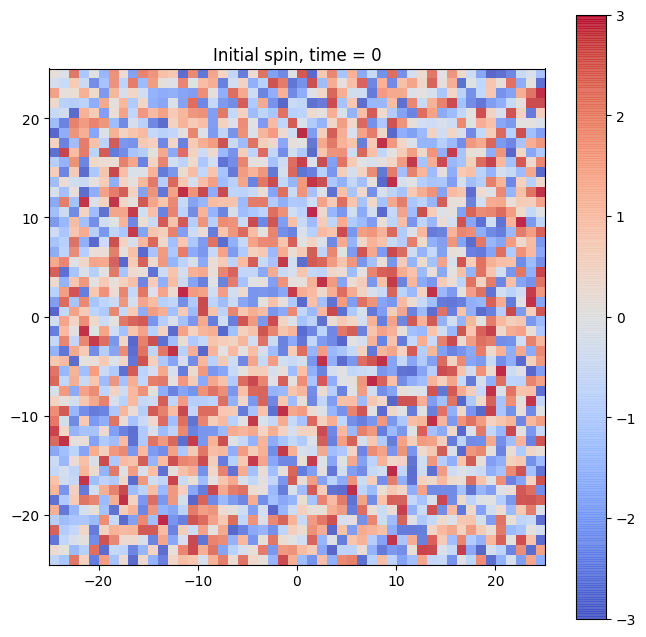

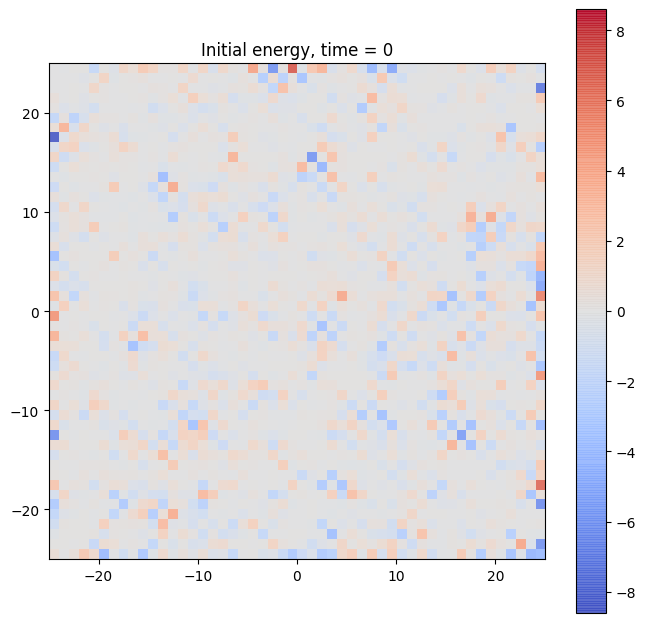

In [ ]:
main(N, n, tmax, spin, J, sigma_x, sigma_y, eta)

# rest all variables
%reset -f